# Analysing Topical Shifts in Migration Publication via Title Words

The titles of publications on migration management give us an overview of what the scientific community focused in their research over the decades.

The dataset consists of authors, titles and publication year of articles published in the journal International Migration (IM) over the period 1961-2011. 

We use Content Analysis as a method to investigate topical shifts in the discourse around migration management. “Content analysis is an approach to the analysis of documents and texts (which may consist of words and/or images and may be printed or online, written or spoken) that seeks to quantify content in terms of predetermined categories and in a systematic and replicable manner.” (Bryman, 2016, p.283).


### References 

Bryman, A. (2016). Social research methods (Fifth edition.). Oxford ; New York: Oxford University Press.



## Loading and inspecting the dataset

We start by loading the dataset in Pandas, which allows us to do basic analysis of the metadata.

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import re


In [2]:
# the name and location of the article records for the IM journal (in CSV format)
records_file = '../data/wiley-IM-records.json'

# load the csv data into a data frame
df = pd.read_json(records_file)
# show the first and last records of the dataset to demonstrate what the records look like
df

,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,journal,volume,issue,issue_title,issue_page_range,issue_pub_date,issue_pub_year,publisher
0,Community Services and Out-Migration,https://onlinelibrary.wiley.com/doi/10.1111/j....,Douglas S. Massey && Nathalie Williams && Will...,"Massey, Douglas S && Williams, Nathalie && Axi...",&& && &&,1-41,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
1,Europe's Migration Agreements with Migrant-Sen...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Aderanti Adepoju && Femke Van Noorloos && Anne...,"Adepoju, Aderanti && van Noorloos, Femke && Zo...",&& &&,42-75,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
2,International Migration and Development in Asi...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Maruja M.B. Asis && Nicola Piper && Parvati Ra...,"Asis, Maruja MB && Piper, Nicola && Raghuram, ...",&& &&,76-106,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
3,Theoretical Considerations and Empirical Evide...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Nicholas P. Glytsos,"Glytsos, Nicholas P",,107-130,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
4,"Causes, Challenges and Prospects of Brain Drai...",https://onlinelibrary.wiley.com/doi/10.1111/j....,Mussie Tessema,"Tessema, Mussie",,131-157,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,ECONOMIC AND SOCIAL REPERCUSSIONS OF SPANISH E...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Luis A. Martinez Cachero,"Cachero, Luis A Martinez",,35-48,06 April 1962,1962,Original Article,Migration,2,2,"Migration: Vol 2, No 2",3-92,April‐June 1962,1962,Wiley
1686,HOW MIGRATION AFFECTS THE COUNTRY OF IMMIGRATION,https://onlinelibrary.wiley.com/doi/10.1111/j....,Francesco M. Dominedo,"Dominedo, Francesco M",,49-60,06 April 1962,1962,Original Article,Migration,2,2,"Migration: Vol 2, No 2",3-92,April‐June 1962,1962,Wiley
1687,Information,https://onlinelibrary.wiley.com/doi/10.1111/j....,None,None,None,61-80,06 April 1962,1962,Information,Migration,2,2,"Migration: Vol 2, No 2",3-92,April‐June 1962,1962,Wiley
1688,DOCUMENTATION,https://onlinelibrary.wiley.com/doi/10.1111/j....,None,None,None,81-90,06 April 1962,1962,Documentation,Migration,2,2,"Migration: Vol 2, No 2",3-92,April‐June 1962,1962,Wiley


### Basic summary statistics

A count of the values in the journal name column, reveals that the metadata of articles has some variation, but almost all use the canonical _International Migration_. In the early years, the journal was called _Migration_ but also _Migracion_ was used. Some contributed articles are written in Spanish or French.



In [3]:
df.journal.value_counts()

International Migration    1629
Migracion                    34
Migration                    27
Name: journal, dtype: int64

#### Publication Years

Counting the number of articles per year reveals that some years had very few articles (e.g. 1979 has only 5), but most years have more than 10. The number of articles per year seems to increase over time. 

<AxesSubplot:xlabel='Issue year', ylabel='Number of articles'>

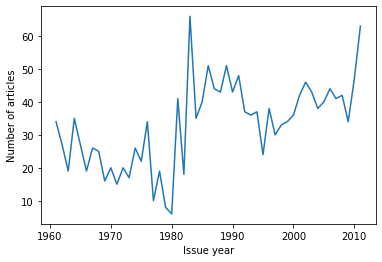

In [4]:
df.issue_pub_year.value_counts().sort_index().plot(xlabel='Issue year', ylabel='Number of articles')

There are a few years with very low numbers of articles, namely the years 1977, 1979, 1980. Listing the articles of those years reveals that each year had only one or two short issues. This could be a signal that there is a mistake in the data extraction process, or that these were just unusual years.

In [5]:
df[df.issue_pub_year.isin([1977, 1979, 1980])].sort_values(by='issue_pub_year')

,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,journal,volume,issue,issue_title,issue_page_range,issue_pub_date,issue_pub_year,publisher
675,Human Rights and the Brain Drain,https://onlinelibrary.wiley.com/doi/10.1111/j....,N.K. ONUOHA CHUKUNTA,"CHUKUNTA, NK ONUOHA",,281-287,01 October 1977,1977,Original Article,International Migration,15,4,"International Migration: Vol 15, No 4",281-318,October 1977,1977,Wiley
1319,Circular Migration in Venezuelan Frontier Areas,https://onlinelibrary.wiley.com/doi/10.1111/j....,MARY ELLEN CONAWAY,"CONAWAY, MARY ELLEN",,35-42,01 January 1977,1977,Original Article,International Migration,15,1,"International Migration: Vol 15, No 1",3-50,January 1977,1977,Wiley
1318,Australia's Immigration Programme: an Evaluati...,https://onlinelibrary.wiley.com/doi/10.1111/j....,MICHAEL T. SKULLEY,"SKULLEY, MICHAEL T",,21-34,01 January 1977,1977,Original Article,International Migration,15,1,"International Migration: Vol 15, No 1",3-50,January 1977,1977,Wiley
1317,Brain drain Issue and Indicators on Brain-Drain,https://onlinelibrary.wiley.com/doi/10.1111/j....,AMALENDU GUHA,"GUHA, AMALENDU",,3-20,01 January 1977,1977,Original Article,International Migration,15,1,"International Migration: Vol 15, No 1",3-50,January 1977,1977,Wiley
1320,Information,https://onlinelibrary.wiley.com/doi/10.1111/j....,None,None,None,43,01 January 1977,1977,Information,International Migration,15,1,"International Migration: Vol 15, No 1",3-50,January 1977,1977,Wiley
1321,"Books, Periodicals, Pamphlets, Statistics",https://onlinelibrary.wiley.com/doi/10.1111/j....,G. BEYER,"BEYER, G",,44-50,01 January 1977,1977,"Books, Periodicals, Pamphlets, Statistics",International Migration,15,1,"International Migration: Vol 15, No 1",3-50,January 1977,1977,Wiley
676,Immigrants in Transition: The Israeli Absorpti...,https://onlinelibrary.wiley.com/doi/10.1111/j....,RUTH TAMAR HOROWITZ,"HOROWITZ, RUTH TAMAR",,288-299,01 October 1977,1977,Original Article,International Migration,15,4,"International Migration: Vol 15, No 4",281-318,October 1977,1977,Wiley
677,Some Current Topics of Labour Migration in Eur...,https://onlinelibrary.wiley.com/doi/10.1111/j....,HEINZ WERNER,"WERNER, HEINZ",,300-307,01 October 1977,1977,Original Article,International Migration,15,4,"International Migration: Vol 15, No 4",281-318,October 1977,1977,Wiley
678,Information,https://onlinelibrary.wiley.com/doi/10.1111/j....,None,None,None,308-309,01 October 1977,1977,Information,International Migration,15,4,"International Migration: Vol 15, No 4",281-318,October 1977,1977,Wiley
679,"Books, Periodicals, Pamphlets, Statistics",https://onlinelibrary.wiley.com/doi/10.1111/j....,None,None,None,310-318,01 October 1977,1977,"Books, Periodicals, Pamphlets, Statistics",International Migration,15,4,"International Migration: Vol 15, No 4",281-318,October 1977,1977,Wiley


Checking the issues for these years on the journal website reveals that these are the only issues available, so there is no mistakes in the extraction process. The fact that only issues 1 and 4 for 1977 are present does suggest that Wiley is missing two issues.

In some years, there are a high number of articles because each original article is published in three languages (English, French and Spanish), for instance Issue 2 in Volume 21 (from 1983). See [https://onlinelibrary.wiley.com/toc/14682435/1983/21/2](https://onlinelibrary.wiley.com/toc/14682435/1983/21/2).

In [6]:
counts = df.issue_pub_year.value_counts()
counts[counts > 50]

1983    66
2011    63
1989    51
1986    51
Name: issue_pub_year, dtype: int64

In [7]:
df[(df.issue_pub_year == 1983) & (df.article_author.isna())][['article_author', 'article_title']]

,article_author,article_title
187,None,"Books, Periodicals, Pamphlets, Statistics"
1199,None,Book Reviews
1200,None,"Books, Periodicals, Pamphlets, Statistics"
1201,None,INTERGOVERNMENTAL COMMITTEE FOR MIGRATION COMI...
1391,None,Addendum
1392,None,"Books, Periodicals, Pamphlets, Statistics"
1532,None,Bibliography on Undocumented Migrants or Migra...
1533,None,Introduction
1534,None,Introduction
1535,None,Introduction


#### Article Titles

Because titles can have variation in the use of uppercase and lowercase, we conduct this analysis on a normalised version of the titles where all characters are transformed to lowercase.



In [8]:
df['lowercase_title'] = df.article_title.str.lower()
title_counts = df.lowercase_title.value_counts()

title_counts

book reviews                                                                                                            46
books, periodicals, pamphlets, statistics                                                                               45
note from the editor                                                                                                    36
introduction                                                                                                            33
information                                                                                                             30
                                                                                                                        ..
economic contribution of migrant workers to thailand                                                                     1
current trends and developments: the immigration reform and control act of 1986: america amends its immigration law*     1
socio-economic d

There are a lot of recurring titles that carry little topical content regarding the discourse on migration. For instance, many issues have an article called 'Introduction' or 'Foreword', which are titles that do not convey any information about what the discourse was about. 

The list of titles that occur more than once contains mostly titles that can be safely removed from the list, although some titles that occur twice should be kept.

In [9]:
title_counts[title_counts > 1]

book reviews                                                                                                                                46
books, periodicals, pamphlets, statistics                                                                                                   45
note from the editor                                                                                                                        36
introduction                                                                                                                                33
information                                                                                                                                 30
recent publications                                                                                                                         20
publications, periodicals, pamphlets, statistics                                                                                            16

Titles the occur more than twice are all labeled as `recurring_title`.

In [10]:
# List all article titles that occur more than twice
list(title_counts[title_counts > 2].index)

['book reviews',
 'books, periodicals, pamphlets, statistics',
 'note from the editor',
 'introduction',
 'information',
 'recent publications',
 'publications, periodicals, pamphlets, statistics',
 'editorial',
 'books received',
 'current trends and developments',
 'list of reviewers',
 'intergovernmental committee for migration comite intergouvernemental pour les migrations comite intergubernamental para las migraciones',
 'documentation',
 'bibliography',
 'international organization for migration',
 'publications received',
 'index',
 'participants']

In [11]:
df['title_count'] = df.groupby(['lowercase_title'])['article_title'].transform('count')
df['recurring_title'] = df.title_count > 2
df[['recurring_title', 'article_title']]
                                           

,recurring_title,article_title
0,False,Community Services and Out-Migration
1,False,Europe's Migration Agreements with Migrant-Sen...
2,False,International Migration and Development in Asi...
3,False,Theoretical Considerations and Empirical Evide...
4,False,"Causes, Challenges and Prospects of Brain Drai..."
...,...,...
1685,False,ECONOMIC AND SOCIAL REPERCUSSIONS OF SPANISH E...
1686,False,HOW MIGRATION AFFECTS THE COUNTRY OF IMMIGRATION
1687,True,Information
1688,True,DOCUMENTATION


In [12]:
df.recurring_title.value_counts()

False    1401
True      289
Name: recurring_title, dtype: int64

There are 289 out of 1690 articles with recurring titles, leaving 1401 titles for analysis.

#### Authors

There are many different authors in the dataset. A value count reveals that some authors published multiple articles in IM, but the majority published only a single article. 

This should also be a warning that some values in the record may be **incorrect**, **incomplete** and/or **inconsistent**, so quantitative analysis should always be complemented with qualitative analysis.

In [13]:
counts = df.article_author.value_counts()
counts[counts > 3]

Reginald Appleyard                          11
W. Dumon Editor                              8
Aderanti Adepoju                             8
Wilfried Dumon Editor                        7
G. BEYER                                     6
Elzbieta M. Gozdziak && Charles B. Keely     6
G. Beyer                                     5
Wilfried Dumon                               4
Robyn Iredale                                4
Charles B. Keely                             4
Susan Martin                                 4
Nicholas P. Glytsos                          4
Name: article_author, dtype: int64

These author names need normalisation to collapse variants like `BEYER, G.` and `Beyer, G.`.

In [14]:
df.article_author.str.lower().str.title().value_counts()

Reginald Appleyard                                                            11
G. Beyer                                                                      11
W. Dumon Editor                                                                8
Aderanti Adepoju                                                               8
Wilfried Dumon Editor                                                          7
                                                                              ..
James K. Chin                                                                  1
Irena Kogan                                                                    1
D. L. Mckee Professor Of Economics && C. A. Tisdell Professor Of Economics     1
Jan Saarela && Dan-Olof Rooth                                                  1
Claire Bishop                                                                  1
Name: article_author, Length: 1058, dtype: int64

This reduces the number of distinct values from 1095 to 1058, so the impact is small, although Gunther Beyer is now among the most frequent author in the dataset.

In [15]:
df.article_author.str.lower().str.title().value_counts().value_counts()

1     952
2      73
3      17
4       6
6       4
11      2
8       2
7       1
5       1
Name: article_author, dtype: int64

There are 952 author names that appear only once, and only a handful authored 4 or more articles. 

There are also many articles with no specified author. It seems that many of these articles are often more about the issue and the articles ('bibliography', 'index') or about the research community ('experts', 'participants') than about migration management. 



In [16]:
df[df.article_author.isna()].recurring_title.value_counts()

True     226
False    217
Name: recurring_title, dtype: int64

More than half of the articles with no specified author has a recurring title. Of the remaining 217 articles, many refer to the community. 

In [17]:
df[(df.article_author.isna()) & (df.recurring_title == False)][['article_title']]

,article_title
9,"Public Law 89-236 89th congress, H. R. 2580 Oc..."
10,Scope for Latin America: ICEM'S CONTRIBUTION T...
11,UN PROJET D'AVENIR POUR L'AMÉRIQUE LATINE
12,AMéRICA LATINA
16,ICEM Language Training for Migrants: KNOWING T...
...,...
1634,Conference on Policy and Research on Migration...
1636,Note of the Editor
1637,Selected publication concerning the integratio...
1651,Migration in the International Press


There are especially many of these non-recurring titles with no author in the years with high numbers of articles, so it seems these are mostly articles that have been published in the three different languages, each time as a separate publication (for instance, [the double issue in 1981](https://onlinelibrary.wiley.com/toc/14682435/1981/19/1%E2%80%902)).


In [18]:

df[(df.article_author.isna()) & (df.recurring_title == False)].issue_pub_year.value_counts()


1983    27
1981    25
1986    15
1976    13
1964    11
1974    11
1965     8
1962     7
1969     7
1961     6
1989     6
1967     6
1992     6
1991     6
1987     5
1979     5
1968     5
1972     4
1966     4
1963     4
1970     4
1994     3
1999     3
1975     3
1982     3
1985     2
1993     2
1998     2
2006     2
2010     1
1988     1
1973     1
1990     1
1971     1
1995     1
1997     1
2002     1
2003     1
2004     1
2008     1
2011     1
Name: issue_pub_year, dtype: int64

For topical analysis, we argue that these can be left out without significantly influencing the outcome and interpretation. Even though some of these articles do seem to have a topical title, they are small in number, and spread across the years so have no distorting effect.

## Data Selection

Before performing a content analysis of the article titles, we want to make a selection of titles that is focused on the academic debate around migration, without any distracting non-topical titles that might obscure any topical shifts across the decades from 1960-1990.

Given the analysis above, we use the following two selection criteria for articles:

1. articles must have a title that does not occur more than twice.
2. articles must have a specified author


In [19]:
df_selected = df[(df.recurring_title == False) & (df.article_author.str.len() > 0)]
df_selected

,article_title,article_doi,article_author,article_author_index_name,article_author_affiliation,article_page_range,article_pub_date,article_pub_year,issue_section,journal,volume,issue,issue_title,issue_page_range,issue_pub_date,issue_pub_year,publisher,lowercase_title,title_count,recurring_title
0,Community Services and Out-Migration,https://onlinelibrary.wiley.com/doi/10.1111/j....,Douglas S. Massey && Nathalie Williams && Will...,"Massey, Douglas S && Williams, Nathalie && Axi...",&& && &&,1-41,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley,community services and out-migration,1,False
1,Europe's Migration Agreements with Migrant-Sen...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Aderanti Adepoju && Femke Van Noorloos && Anne...,"Adepoju, Aderanti && van Noorloos, Femke && Zo...",&& &&,42-75,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley,europe's migration agreements with migrant-sen...,1,False
2,International Migration and Development in Asi...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Maruja M.B. Asis && Nicola Piper && Parvati Ra...,"Asis, Maruja MB && Piper, Nicola && Raghuram, ...",&& &&,76-106,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley,international migration and development in asi...,1,False
3,Theoretical Considerations and Empirical Evide...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Nicholas P. Glytsos,"Glytsos, Nicholas P",,107-130,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley,theoretical considerations and empirical evide...,1,False
4,"Causes, Challenges and Prospects of Brain Drai...",https://onlinelibrary.wiley.com/doi/10.1111/j....,Mussie Tessema,"Tessema, Mussie",,131-157,26 April 2010,2010,ORIGINAL ARTICLES,International Migration,48,3,"International Migration: Vol 48, No 3",1-193,June 2010,2010,Wiley,"causes, challenges and prospects of brain drai...",1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,Peopling Skilled International Migration: Indi...,https://onlinelibrary.wiley.com/doi/10.1111/14...,Vaughan Robinson && Malcolm Carey,"Robinson, Vaughan && Carey, Malcolm",&&,89-108,16 December 2002,2002,Original Articles,International Migration,38,1,"International Migration: Vol 38, No 1",3-137,March 2000,2000,Wiley,peopling skilled international migration: indi...,1,False
1679,Ecological Succession and Asian Immigrants in ...,https://onlinelibrary.wiley.com/doi/10.1111/14...,Xiaowei Zang,"Zang, Xiaowei",,109-125,16 December 2002,2002,Original Articles,International Migration,38,1,"International Migration: Vol 38, No 1",3-137,March 2000,2000,Wiley,ecological succession and asian immigrants in ...,1,False
1684,"OVERSEAS MIGRATION TO AND FROM AUSTRALIA, 1947...",https://onlinelibrary.wiley.com/doi/10.1111/j....,Charles A. Price M. A.;Ph.D.,"Price, Charles A",,21-34,06 April 1962,1962,Original Article,Migration,2,2,"Migration: Vol 2, No 2",3-92,April‐June 1962,1962,Wiley,"overseas migration to and from australia, 1947...",1,False
1685,ECONOMIC AND SOCIAL REPERCUSSIONS OF SPANISH E...,https://onlinelibrary.wiley.com/doi/10.1111/j....,Luis A. Martinez Cachero,"Cachero, Luis A Martinez",,35-48,06 April 1962,1962,Original Article,Migration,2,2,"Migration: Vol 2, No 2",3-92,April‐June 1962,1962,Wiley,economic and social repercussions of spanish e...,1,False


This leaves 1183 out of 1690 article titles for analysis.

## Analysing the Article Titles

To analyse the topics of discourse, we use the article titles. To do a content analysis, some data transformations are needed:

- standardising the use of upper and lowercase characters,
- removing common stopwords, as they convey nothing about the topics discussed
- counting individual words and sequences of words as a quantitative signal for the attention to different topics.

We look specifically at:

- word unigram frequencies: how often individual words occur across titles
- word bigram frequencies: how often combinations of two words occur across titles.

To demonstrate the need for the transformations described above, we look at the first 20 titles.

In [20]:
# Get a list of all the titles
titles = list(df_selected.article_title)

# show the first 20 titles
titles[:20]



['Community Services and Out-Migration',
 "Europe's Migration Agreements with Migrant-Sending Countries in the Global South: A Critical Review",
 'International Migration and Development in Asia: Exploring Knowledge Frameworks',
 "Theoretical Considerations and Empirical Evidence on Brain Drain Grounding the Review of Albania's and Bulgaria's Experience 1",
 'Causes, Challenges and Prospects of Brain Drain: The Case of Eritrea',
 'A Desire to Return to the Country of Birth as a Function of Language Preference: An Empirical Study with Iranian Immigrants in the United States',
 'Religious Status and Drug-use Behaviour among Former Soviet Union Immigrants',
 '“Reconsidering the Study of International Migration: A Way Forward for Macrostructural Migration Research”',
 'The New U.S.A. Immigration Law',
 'Post-War Migration to Switzerland*',
 'The Decline in Religious Participation of Migrants',
 'The Repatriation of French Algerians 1962-1963',
 'The Migration Problem And The Encyclical “Ma

#### Inconsistent Case

The titles differ in their use of upper and lower case, so one step is to normalise all titles to be lower case. 

One consequence of this is that meaningful differences between a word with an initial uppercase that is part of a name (like _Migration_ in the organisation name _Internationl Committee for European Migration_) is merged with the regular noun _migration_. But in most cases this is not a problem, as they represent the same concept. Moreover, titles of journal article tend to use title casing of all words in the title, or at least all content-bearing words (i.e. non-stopwords). So it is difficult to make this distinction with algorithmic processing anyway.



In [21]:
# show the first 20 titles
[title.lower() for title in titles[:20]]



['community services and out-migration',
 "europe's migration agreements with migrant-sending countries in the global south: a critical review",
 'international migration and development in asia: exploring knowledge frameworks',
 "theoretical considerations and empirical evidence on brain drain grounding the review of albania's and bulgaria's experience 1",
 'causes, challenges and prospects of brain drain: the case of eritrea',
 'a desire to return to the country of birth as a function of language preference: an empirical study with iranian immigrants in the united states',
 'religious status and drug-use behaviour among former soviet union immigrants',
 '“reconsidering the study of international migration: a way forward for macrostructural migration research”',
 'the new u.s.a. immigration law',
 'post-war migration to switzerland*',
 'the decline in religious participation of migrants',
 'the repatriation of french algerians 1962-1963',
 'the migration problem and the encyclical “ma

For analysing in how many titles each word occurs, there are several other issues:

- some titles have footnote symbols like '*' and '1', which are not part of the words they are attached to. For example: "theoretical considerations and empirical evidence on brain drain grounding the review of albania's and bulgaria's experience 1"
    - **The normalisation step is to remove these symbols.**
- some words contain contractions like "Europe's". We only want to count the content word, e.g. 'Europe'. 
    - **The normalisation step is to remove the 's part to retain only the content word.**
- some titles contain acronyms with dots, like A.D., C.E.E. or U.S.A. 
    - **The normalisation steps is to remove the dots.**
- We want to compare plain words without any attached punctuation, such that “mater et magistra” should become three words 'mater', 'et', 'magistra' without the opening and closing double quote characters
    - **The normalisation step is to replace all such punctuation symbols by a whitespace, so that their removal doesn't contract two words on opposite so of the punctuation.**
    - **The exception is hyphenated words, which should remain intact, e.g. 'co-development' should be treated as a single word.**
    
    

In [22]:
def remove_footnote_symbols(title):
    """Remove footnote symbols in the title like * and 1."""
    title = re.sub(r'([a-z]+)[12]', r'\1', title)
    if title.endswith('*'):
        return title[:-1]
    elif title.endswith(' 1'):
        return title[:-2]
    else:
        return title
    
    
def normalise_acronyms(title):
    """Remove dots in acronyms (A.D. -> AD , U.S.A. -> USA)"""
    match = re.search(r'\b((\w\.){2,})', title)
    if match:
        acronym = match.group(1)
        normalised_acronym = acronym.replace('.','')
        title = title.replace(acronym, normalised_acronym)
    return title
        

def resolve_apostrophes(title):
    """Remove 's from words."""
    title = title.replace("‘", "'")
    title = re.sub(r"(\w)'s\b", r'\1', title)
    return title


def remove_punctuation(title):
    """Remove all non-alpha-numeric characters except whitespace and hyphens"""
    title = re.sub(r'[^\w -]', ' ', title)
    return title


def collapse_multiple_whitespace(title):
    """Reduce multiple whitespace to a single whitespace, e.g. '  ' -> ' '. """
    title = re.sub(r' +', ' ', title)
    return title


def normalise_title(title):
    title = remove_footnote_symbols(title)
    title = normalise_acronyms(title)
    title = resolve_apostrophes(title)
    title = remove_punctuation(title)
    title = collapse_multiple_whitespace(title)
    return title.lower()

def demonstrate_normalisation():
    titles = list(df_selected.article_title)
    for title in titles:
        print('Original:', title)
        title = normalise_title(title)
        print('Normalised:', title)
        print()

demonstrate_normalisation()


Original: Community Services and Out-Migration
Normalised: community services and out-migration

Original: Europe's Migration Agreements with Migrant-Sending Countries in the Global South: A Critical Review
Normalised: europe migration agreements with migrant-sending countries in the global south a critical review

Original: International Migration and Development in Asia: Exploring Knowledge Frameworks
Normalised: international migration and development in asia exploring knowledge frameworks

Original: Theoretical Considerations and Empirical Evidence on Brain Drain Grounding the Review of Albania's and Bulgaria's Experience 1
Normalised: theoretical considerations and empirical evidence on brain drain grounding the review of albania and bulgaria experience

Original: Causes, Challenges and Prospects of Brain Drain: The Case of Eritrea
Normalised: causes challenges and prospects of brain drain the case of eritrea

Original: A Desire to Return to the Country of Birth as a Function of L

Normalised: views of non-governmental organizations on family migration

Original: Placement Assistance to returning Migrants and other Type of Assistance including Reception and Accommodation
Normalised: placement assistance to returning migrants and other type of assistance including reception and accommodation

Original: Vocational Training Courses for returning Migrants before their Departure from the Country of Immigration and after their Arrival in the Country of Origin
Normalised: vocational training courses for returning migrants before their departure from the country of immigration and after their arrival in the country of origin

Original: The Relation between Migration Policy and Economic Development and the Promotion of New Employment Possibilities for Returnees (Foreign Investment and Migrant Remittances)
Normalised: the relation between migration policy and economic development and the promotion of new employment possibilities for returnees foreign investment and migrant

Normalised: the adaptation and integration of selective immigrants in brazil report on an enquiry

Original: Migrants, Refugees and Insecurity. Current Threats to Peace?
Normalised: migrants refugees and insecurity current threats to peace 

Original: Return and Responsibility
Normalised: return and responsibility

Original: The Demographic and Socio-Economic Characteristics of Post-1965 Immigrants to New York City: A Comparative Analysis by National Origin
Normalised: the demographic and socio-economic characteristics of post-1965 immigrants to new york city a comparative analysis by national origin

Original: Profiles of Refugee and Non-Refugee Palestinians from the West Bank and Gaza
Normalised: profiles of refugee and non-refugee palestinians from the west bank and gaza

Original: Emigration and Development: The Case of a Bangladeshi Village
Normalised: emigration and development the case of a bangladeshi village

Original: Secularism as a Barrier to Integration? The French Dilemma

Normalised: economics of human trafficking

Original: Trafficking and Contract Migrant Workers in the Middle East
Normalised: trafficking and contract migrant workers in the middle east

Original: Minors Travelling Alone: A Risk Group for Human Trafficking?
Normalised: minors travelling alone a risk group for human trafficking 

Original: Assisted Voluntary Return of Irregular Migrants: Policy and Practice in the Slovak Republic
Normalised: assisted voluntary return of irregular migrants policy and practice in the slovak republic

Original: Race, Class and the Shaping of a Policy for Immigrants: The Case of the Netherlands
Normalised: race class and the shaping of a policy for immigrants the case of the netherlands

Original: Adjustment of Immigrants in Canada: Methodological Possibilities and its Implications*
Normalised: adjustment of immigrants in canada methodological possibilities and its implications

Original: Birds of Passage No More: Migration Decision Making among Filipino Im

Normalised: transatlantic roundtable on low-skilled migration in the twenty-first century prospect and policies

Original: Seeking Asylum Alone: Treatment of Separated and Trafficked Children in Need of Refugee Protection
Normalised: seeking asylum alone treatment of separated and trafficked children in need of refugee protection

Original: Poultry, Apples, and New Immigrants in the Rural Communities of the Shenandoah Valley: An Ethnographic Case Study
Normalised: poultry apples and new immigrants in the rural communities of the shenandoah valley an ethnographic case study

Original: Changing Characteristics of Refugees as Immigrants to Australia
Normalised: changing characteristics of refugees as immigrants to australia

Original: Intra-COMECON Manpower Migration
Normalised: intra-comecon manpower migration

Original: Were the Jewish Immigrants to the United States Representative of Russian Jews?
Normalised: were the jewish immigrants to the united states representative of russian jew

Normalised:  economically speaking i am the breadwinner chinese immigrant narratives of work and family in hong kong

Original: “Not a Real Worker”: Gendering Migrants in Thailand's Shrimp Farms
Normalised:  not a real worker gendering migrants in thailand shrimp farms

Original: Performances across Time and Space: Drama in the Global Households of Filipina Transmigrant Workers
Normalised: performances across time and space drama in the global households of filipina transmigrant workers

Original: Mexican Seasonal Migration to Canada and Development: A Community-based Comparison
Normalised: mexican seasonal migration to canada and development a community-based comparison

Original: Migration and the Reproduction of Poverty: The Refugee Camps in Jordan
Normalised: migration and the reproduction of poverty the refugee camps in jordan

Original: Highly Skilled and Business Migrants: Information Processes and Settlement Outcomes
Normalised: highly skilled and business migrants information 

Normalised: survival of the fittest russian immigrant teachers speak about their professional adjustment in israel

Original: Voice, Agency and Vulnerability: the Immigration of Children through Systems of Protection and Enforcement
Normalised: voice agency and vulnerability the immigration of children through systems of protection and enforcement

Original: Return of Separated Children: The Impact of Dutch Policies
Normalised: return of separated children the impact of dutch policies

Original: Methods, Approaches and Data Sources for Estimating Stocks of Irregular Migrants
Normalised: methods approaches and data sources for estimating stocks of irregular migrants

Original: The Size of the Irregular Migrant Population in the European Union - Counting the Uncountable?
Normalised: the size of the irregular migrant population in the european union - counting the uncountable 

Original: Measuring Irregular Migration and Population Flows - What Available Data Can Tell
Normalised: measurin


Original: ECONOMIC AND SOCIAL REPERCUSSIONS OF SPANISH EMIGRATION TO COUNTRIES OVERSEAS
Normalised: economic and social repercussions of spanish emigration to countries overseas

Original: HOW MIGRATION AFFECTS THE COUNTRY OF IMMIGRATION
Normalised: how migration affects the country of immigration



### Word Frequency Lists

We start with a quick look at individual word frequencies for the first 20 titles to get an insight in some easy that need preprossing.

In [23]:
from collections import Counter # import to count word frequencies


# count frequencies of individual words
uni_freq = Counter()

for title in titles[:20]:
    # normalise the title using the steps described above
    title = normalise_title(title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # count each term in the sentence, excluding 'empty' words
    uni_freq.update([term for term in terms if term != ''])

# Show the 25 most common words and their frequencies
for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')

the                              15
of                               13
migration                        10
and                               7
in                                6
a                                 5
to                                5
country                           3
study                             3
with                              2
countries                         2
review                            2
international                     2
development                       2
empirical                         2
brain                             2
drain                             2
as                                2
an                                2
immigrants                        2
religious                         2
for                               2
immigration                       2
best                              2
community                         1


#### Stopwords and Content Words

Now we notice that the most frequent words are stopwords. We can use a standard stopword list provided by [NLTK](http://www.nltk.org) to remove those from the frequency lists to focus on the content words.

Since there are publications in English, French and Spanish, we use the stopword lists of all three languages.

In [24]:
from collections import Counter # import to count word frequencies
import re # import to remove punctuation
from nltk.corpus import stopwords # import to remove stopwords

stopwords_en = stopwords.words('english')
stopwords_fr = stopwords.words('french')
stopwords_sp = stopwords.words('spanish')
stopwords_all = stopwords_en + stopwords_fr + stopwords_sp

print('The first 10 English stopwords:', stopwords_en[:10])
print('The first 10 French stopwords:', stopwords_fr[:10])
print('The first 10 Spanish stopwords:', stopwords_sp[:10])
print('\nTotal number of distinct stopwords:', len(stopwords_all))

The first 10 English stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']
The first 10 French stopwords: ['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle']
The first 10 Spanish stopwords: ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se']

Total number of distinct stopwords: 621


In [25]:
# count frequencies of individual words
uni_freq = Counter()

for title in titles[:20]:
    # normalise the title using the steps described above
    title = normalise_title(title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # remove stopwords
    terms = [term for term in terms if term not in stopwords_all]
    # count each term in the sentence, excluding 'empty' words
    uni_freq.update([term for term in terms if term != ''])

for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



migration                        10
country                           3
study                             3
countries                         2
review                            2
international                     2
development                       2
empirical                         2
brain                             2
drain                             2
immigrants                        2
religious                         2
immigration                       2
best                              2
community                         1
services                          1
out-migration                     1
europe                            1
agreements                        1
migrant-sending                   1
global                            1
south                             1
critical                          1
asia                              1
exploring                         1


Now we have a list of mostly content words. Note that the stopwords list contains English stopwords, so common stopwords in other languages are not filtered out. We assume these are not very common so will leave them in for now. 

Now we repeat the the frequency counting for all 1183 titles, instead of the first 20.

In [26]:
# count frequencies of individual words
uni_freq = Counter()

for title in titles:
    # normalise the title using the steps described above
    title = normalise_title(title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # remove stopwords
    terms = [term for term in terms if term not in stopwords_all]
    # count each term in the sentence, excluding 'empty' words
    uni_freq.update([term for term in terms if term != ''])

for term, freq in uni_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



migration                       363
immigrants                      110
migrants                         91
immigration                      86
international                    79
labour                           74
case                             70
migrant                          68
australia                        68
new                              60
social                           58
policy                           57
united                           56
immigrant                        55
refugees                         54
states                           52
workers                          51
countries                        50
emigration                       50
economic                         48
return                           47
canada                           46
study                            45
women                            45
among                            41


#### Word Bigrams

Next, we look at combinations of two words. Individual words can have quite different meanings in different contexts. Two neighbouring words in a title tend to contextualise each other, so convey more meaning.

We create word bigrams in the following way:

- we split the normalised title into individual words
- we create bigrams for each two adjacent words, so 'evidence on brain drain' results in three bigrams:
    - 'evidence on', 'on brain', 'brain drain'
- we remove all bigrams in which either the first or the second word is a stopword, assuming that the stopword convey little contextual information.

First we look at how this process transforms a title to a list of bigrams, and discuss how that affects frequencies.

In [27]:
for title in titles[:20]:
    # normalise the title using the steps described above
    title = normalise_title(title)
    print('Title:', title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # get all pairs of subsequent title words
    bigrams = list(zip(terms[:-1], terms[1:]))
    print('\nAll bigrams:', [' '.join(bigram) for bigram in bigrams])
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams if bigram[0] not in stopwords_all and bigram[1] not in stopwords_all]
    print('\nFiltered bigrams:', bigram_terms)
    print('\n')


Title: community services and out-migration

All bigrams: ['community services', 'services and', 'and out-migration']

Filtered bigrams: ['community services']


Title: europe migration agreements with migrant-sending countries in the global south a critical review

All bigrams: ['europe migration', 'migration agreements', 'agreements with', 'with migrant-sending', 'migrant-sending countries', 'countries in', 'in the', 'the global', 'global south', 'south a', 'a critical', 'critical review']

Filtered bigrams: ['europe migration', 'migration agreements', 'migrant-sending countries', 'global south', 'critical review']


Title: international migration and development in asia exploring knowledge frameworks

All bigrams: ['international migration', 'migration and', 'and development', 'development in', 'in asia', 'asia exploring', 'exploring knowledge', 'knowledge frameworks']

Filtered bigrams: ['international migration', 'asia exploring', 'exploring knowledge', 'knowledge frameworks']


T

Now we process all titles and count how often each word bigram occurs. The 25 most frequent bigrams are displayed for analysis.

In [28]:
# count frequencies of individual words
bi_freq = Counter()

for title in titles:
    # normalise the title using the steps described above
    title = normalise_title(title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # get all pairs of subsequent title words
    bigrams = list(zip(terms[:-1], terms[1:]))
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams if bigram[0] not in stopwords_all and bigram[1] not in stopwords_all]
    # count the occurrence of each bigram
    bi_freq.update(bigram_terms)


for term, freq in bi_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



international migration          51
united states                    47
labour market                    21
labour migration                 20
case study                       19
migrant workers                  18
brain drain                      17
emigration dynamics              17
return migration                 15
immigration policy               13
developing countries             13
human trafficking                13
migrant women                    13
new zealand                      12
middle east                      10
former soviet                     9
foreign workers                   9
latin american                    9
soviet union                      8
sub-saharan africa                8
hong kong                         8
among immigrants                  8
migration policy                  8
asylum seekers                    8
irregular migration               7


Now, 'international migration' is the most common two-word combination, followed by 'United States', 'labour market', 'labour migration', 'case study', 'migrant workers' and 'brain drain'.

It is no surprise that bigrams containing the word 'migration' or 'migrant' are frequent, but the bigrams result in meaningful distinctions like 'labour migration' versus 'return migration' and 'migrant workers' versus 'migrant women'.

#### Assessing the Impact of Normalisation

In [29]:
# count frequencies of individual words
bi_freq = Counter()

for title in titles:
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # get all pairs of subsequent title words
    bigrams = list(zip(terms[:-1], terms[1:]))
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams if bigram[0] not in stopwords_all and bigram[1] not in stopwords_all]
    # count the occurrence of each bigram
    bi_freq.update(bigram_terms)


for term, freq in bi_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



International Migration          38
The Case                         36
United States                    30
Labour Market                    19
Case Study                       18
Labour Migration                 15
Emigration Dynamics              15
The Impact                       14
Return Migration                 12
International Migration:         11
The Role                         11
Migrant Workers                  11
Migration: The                   11
Developing Countries             11
Migrant Women                    11
A Case                           10
A Comparative                    10
Human Trafficking                10
Former Soviet                     9
Foreign Workers                   9
Brain Drain                       8
Soviet Union                      8
Immigration Policy                8
Hong Kong                         8
United States:                    8


#### Assessing the impact of removing bigrams with stopwords

In [30]:
# count frequencies of individual words
bi_freq = Counter()

for title in titles:
    # normalise the title using the steps described above
    title = normalise_title(title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # remove stopwords before making bigrams
    terms = [term for term in terms if term not in stopwords_all]
    # get all pairs of subsequent title words
    bigrams = list(zip(terms[:-1], terms[1:]))
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams]
    # count the occurrence of each bigram
    bi_freq.update(bigram_terms)


for term, freq in bi_freq.most_common(25):
    print(f'{term: <30}{freq: >5}')
    



international migration          51
united states                    47
labour market                    21
labour migration                 20
case study                       19
migrant workers                  18
brain drain                      17
emigration dynamics              17
return migration                 15
immigration policy               13
developing countries             13
human trafficking                13
migrant women                    13
new zealand                      12
middle east                      10
former soviet                     9
foreign workers                   9
immigrants australia              9
latin american                    9
countries origin                  9
migration development             8
soviet union                      8
sub-saharan africa                8
immigrants canada                 8
hong kong                         8




### Analysing Title Words Per Decade

The articles are published over a period of several decades, and there might be shifts in the discourse over time. A next step is to group uni-grams and bi-grams per decade, to visualise shifts.

The first step is to group the article titles per decade. We derive the decade from the year that the issue was published. 

In [31]:
# adding a column per article with the publication decade
df['issue_decade'] = df.issue_pub_year.apply(lambda x: int(x/10) * 10 if not pd.isnull(x) else x)
# recreate the selection of the dataset with the new column
df_selected = df[(df.recurring_title == False) & (df.article_author.str.len() > 0)]

df_selected[['issue_pub_year', 'issue_decade']]



,issue_pub_year,issue_decade
0,2010,2010
1,2010,2010
2,2010,2010
3,2010,2010
4,2010,2010
...,...,...
1678,2000,2000
1679,2000,2000
1684,1962,1960
1685,1962,1960


The number of articles per decade shows that there is a slight dip in the 1970s, but after that increases per decade.

In [32]:
df_selected.issue_decade.value_counts().sort_index()

1960    124
1970    109
1980    220
1990    267
2000    359
2010    104
Name: issue_decade, dtype: int64

In [33]:
# make a list of all decades in the dataset
decades = sorted([int(decade) for decade in list(set(df_selected.issue_decade)) if not pd.isnull(decade)])
decades

[1960, 1970, 1980, 1990, 2000, 2010]

#### Analysing content words per decade

In [34]:
def make_title_unigram_term_list(title: str, stopwords):
    # normalise the title using the steps described above
    title = normalise_title(title)
    # .split(' ') splits the title into chunks wherever there is a whitespace
    terms = title.split(' ')
    # remove stopwords
    terms = [term for term in terms if term not in stopwords]
    return terms


for decade in decades:
    titles = list(df_selected[df_selected.issue_decade == decade].article_title)
    normalised_titles = [normalise_title(title) for title in titles]
    unigram_terms = [term for title in normalised_titles for term in make_title_unigram_term_list(title, stopwords_all)]
    unigram_freq = Counter(unigram_terms)
    print(decade)
    print('--------------------------')
    for term, freq in unigram_freq.most_common(25):
        print(f'{term: <30}{freq: >5}')
    print('\n\n')
    



1960
--------------------------
migration                        29
immigration                      16
australia                        12
emigration                       11
immigrants                       10
australian                        8
development                       7
european                          7
social                            7
immigrant                         6
america                           6
assimilation                      6
international                     6
country                           5
europe                            5
integration                       5
refugees                          5
economic                          5
western                           5
migrants                          4
aspects                           4
study                             4
icem                              4
latin                             4
influence                         4



1970
--------------------------
migration                        

In [35]:
def make_title_bigram_term_list(title: str, stopwords):
    # first turn the title into a list of normalised words, but don't remove stopwords
    terms = make_title_unigram_term_list(title, [])
    # get all pairs of subsequent words in the title
    bigrams = list(zip(terms[:-1], terms[1:]))
    # remove all bigrams for which the first or second word is a stopword
    bigram_terms = [' '.join(bigram) for bigram in bigrams 
                    if bigram[0] not in stopwords and bigram[1] not in stopwords]
    return bigram_terms


for decade in decades:
    titles = list(df_selected[df_selected.issue_decade == decade].article_title)
    normalised_titles = [normalise_title(title) for title in titles]
    bigram_terms = [term for title in titles for term in make_title_bigram_term_list(title, stopwords_all)]
    bigram_freq = Counter(bigram_terms)
    print(decade)
    print('--------------------------')
    for term, freq in bigram_freq.most_common(25):
        print(f'{term: <30}{freq: >5}')
    print('\n\n')
    



1960
--------------------------
latin america                     4
brain drain                       3
international migration           3
western australia                 3
migration affects                 2
immigrants returning              2
selective migration               2
rural settlement                  2
united states                     2
polish immigrants                 2
immigration policy                2
new usa                           1
usa immigration                   1
immigration law                   1
post-war migration                1
religious participation           1
french algerians                  1
algerians 1962-1963               1
migration problem                 1
encyclical mater                  1
magistra historical               1
historical development            1
moral aspects                     1
human migration                   1
1500 ad                           1



1970
--------------------------
united states                    

### Analysing Countries Mentioned in Titles

We map countries to continents, as larger geographic units.

In some titles, the nationality of a migrant group is mentioned, which differs from the country name. We add an analysis in which also nationalities are mapped to their respective country names and continents. E.g. `Polish` is mapped to `Poland` and `Europe`. 

We started with the countries and continents listed on the [World Atlas](https://www.worldatlas.com/cntycont.htm) website, and extended these several former countries (e.g. Soviet Union) and not formally-recognised countries (e.g. Kosovo, Palestina) as well as some larger regions (Caribbean, Latin America, Middle East). For the UK, we included England, Northern Ireland, Scotland and Wales, as these are also mentioned in some titles. 

For the nationalities, we used a list provided by Wikipedia ([List of adjectival and demonymic forms for countries and nations](https://en.wikipedia.org/w/index.php?title=List_of_adjectival_and_demonymic_forms_for_countries_and_nations&oldid=1004136953)).


In [40]:
from scripts.countries import CountryLookup, show_counts

lookup = CountryLookup()

titles = list(df_selected.article_title)

# First we count without nationalities
country_count, continent_count = lookup.count_countries_continents(titles, include_nationalities=False)


show_counts(country_count, continent_count)

Countries
----------------------------------
Australia                       80
United States                   56
Canada                          46
Israel                          40
Germany                         19
Sweden                          18
India                           17
Latin America                   15
Mexico                          14
Japan                           14
Greece                          12
New Zealand                     12
Middle East                     11
Cuba                            10
Vietnam                         10
Brazil                          10
Turkey                           9
Netherlands                      9
China                            9
Spain                            9


Continents
----------------------------------
Europe                         205
Asia                           198
North America                  129
Oceania                         92
Africa                          74
South America                   

In [41]:
# Next we count with nationalities included
country_count, continent_count = lookup.count_countries_continents(titles, include_nationalities=True)

show_counts(country_count, continent_count)

Countries
----------------------------------
Australia                       80
United States                   75
Canada                          65
Israel                          40
China                           29
Mexico                          25
Germany                         23
Greece                          23
Turkey                          21
Macau                           21
Sweden                          20
India                           17
Netherlands                     16
Italy                           15
Latin America                   15
Japan                           14
Spain                           12
New Zealand                     12
France                          11
United Kingdom                  11


Continents
----------------------------------
Europe                         270
Asia                           233
North America                  168
Oceania                         92
Africa                          80
South America                   

In [42]:
decades = [1960, 1970, 1980, 1990, 2000, 2010]

for decade in decades:
    print(decade)
    print('\n')
    titles = list(df_selected[df_selected.issue_decade == decade].article_title)
    country_count, continent_count = lookup.count_countries_continents(titles, include_nationalities=True)
    show_counts(country_count, continent_count)
    print('\n\n')

1960


Countries
----------------------------------
Australia                       20
United States                    7
Canada                           5
Latin America                    4
United Kingdom                   4
Brazil                           4
France                           3
Hungary                          3
Italy                            3
Netherlands                      3
Greece                           2
Norway                           2
Poland                           2
Germany                          2
Israel                           2
Spain                            2
Switzerland                      1
Algeria                          1
Argentina                        1
Malta                            1


Continents
----------------------------------
Europe                          35
Oceania                         20
North America                   11
South America                    9
Africa                           4
Asia                     